# LangGraph Chatbots with External Tools
* Notebook by Adam Lang
* Date: 1/16/2025

# Overview
* In this notebook I will build and implement a chatbot with agents in langgraph that includes use of external tools.

# Architecture
* The flow diagram I created below shows the flow states of the application.
1. User queries the app.
2. State initialized in langgraph and query sent to chatbot node.
3. If chatbot node can answer the user query it will call the GROQ API and an open-source LLM of choice and return the answer and end the flow.
4. However, the node has access now to a few external tools via multiple agents can use those tools to access external information to bring back to the chatbot and LLM to synthesize a more complete response to the user query.

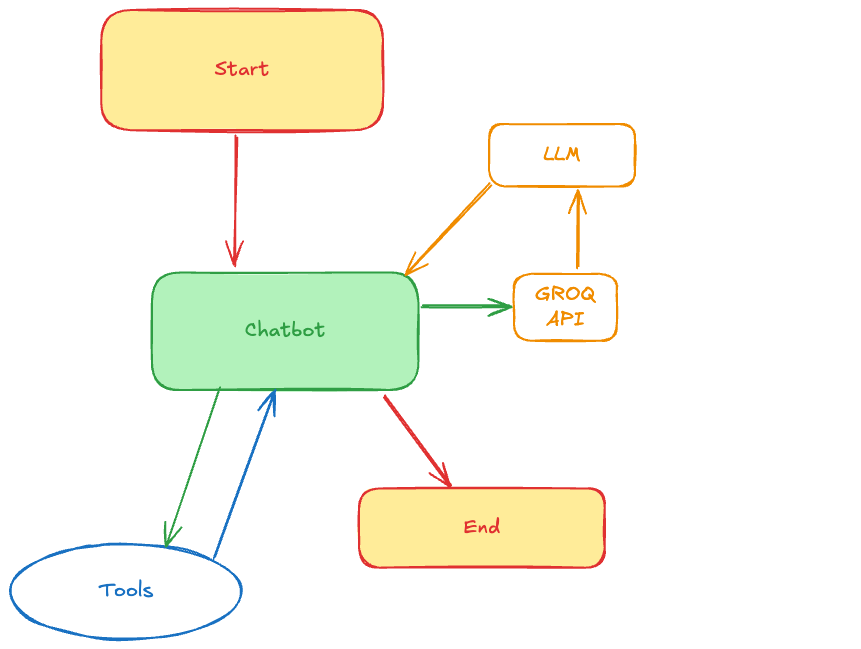

# Install Dependencies

In [1]:
%%capture
!pip install langgraph langsmith langchain langchain_groq langchain_community arxiv wikipedia

In [19]:
from typing import Annotated
from typing_extensions import TypedDict
import os
from getpass import getpass

## langraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.callbacks import StdOutCallbackHandler
from langchain.schema import HumanMessage
from langchain_groq import ChatGroq ## llm connection

## tool imports
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langgraph.prebuilt import ToolNode, tools_condition

# API and Environment Variables

In [3]:
## imports -- run this cell if you
## don't have your key stored in a secrets or .env file

GROQ_API_KEY = getpass("Enter your GROQ API key: ")

Enter your GROQ API key: ··········


In [4]:
## setup environment variable

os.environ['GROQ_API_KEY'] = GROQ_API_KEY

# Setup Tools

In [5]:
## arxiv tool setup
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

## wikipedia tool setup
api_wrapper=WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

# Testing the tools
* Lets test the API tools before we implement them.

In [6]:
## wiki tool
wiki_tool.invoke("who is Tom Cruise")

'Page: Tom Cruise filmography\nSummary: Tom Cruise is an American actor and producer who made his film debut with a minor role in the 1981 romantic drama Endless Love. Two years later, he made his breakthrough by starring in the romantic comedy Risky Business (1983), which garnered his first nominatio'

In [7]:
## arxiv tool
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

Summary
* We can easily see both API tools work.

# Final Tool setup
* We need to append the tools to a list to use them.

In [20]:
## tool list
tools = [wiki_tool]
tools

[WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/usr/local/lib/python3.11/dist-packages/wikipedia/__init__.py'>, top_k_results=1, lang='en', load_all_available_meta=False, doc_content_chars_max=300))]

# LangGraph Application
* Now we will implement the LangGraph application using the standard flow.

In [21]:
## create State class
class State(TypedDict):
  messages:Annotated[list,add_messages]

## create stategraph
graph_builder = StateGraph(State)
graph_builder


## Setup LLM connection via GROQ API

In [22]:
## load llm
llm=ChatGroq(groq_api_key=GROQ_API_KEY, model_name='gemma2-9b-it')
llm


ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7b961f93ed50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7b961f103a10>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

## Create Chatbot

In [23]:
## 1. bind tools
llm_with_tools=llm.bind_tools(tools=tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7b961f93ed50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7b961f103a10>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'wikipedia', 'description': 'A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'query to look up on wikipedia', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [24]:
## chatbot function
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [26]:
## 1. create chatbot --> start nodes
# check if node is already in graph
if "chatbot" not in graph_builder.nodes:
  graph_builder.add_node("chatbot", chatbot) ## add if not exist already
graph_builder.add_edge(START, "chatbot")

## 2. call tool node
tool_node=ToolNode(tools=tools)

## 3. connect tool nodes
graph_builder.add_node("tools", tool_node)

## 4. add conditional edges -- from `graph_builder`
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

## 5. connect chatbot with tools and end edge
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

## 6. compile graph
graph=graph_builder.compile()

## Display Graph

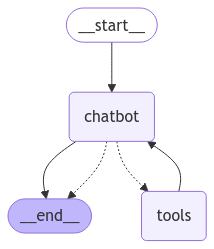

In [27]:
## display graph
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

# Testing the Chatbot

In [47]:
## user input
user_input="Who was President of the USA when the Buffalo Bills were last in the Super Bowl, and what year was it?"

## events stream
events=graph.stream(
    {"messages": [("user", user_input)]}, stream_mode="values"
)
## get response
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Who was President of the USA when the Buffalo Bills were last in the Super Bowl, and what year was it?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_g0j5)
 Call ID: call_g0j5
  Args:
    query: Last Super Bowl appearance of the Buffalo Bills
================================= Tool Message =================================
Name: wikipedia

Page: Super Bowl XXVIII
Summary: Super Bowl XXVIII was an American football game between the National Football Conference (NFC) champion Dallas Cowboys and the American Football Conference (AFC) champion Buffalo Bills to decide the National Football League (NFL) champion for the 1993 season. The Cow
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_cc2q)
 Call ID: call_cc2q
  Args:
    query: President of the USA in 1993
===========================